In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal, integrate

from scifit.solvers import FitSolver1D

from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
R = 8.31446261815324  # J/mol.K
T0 = 292.05           # K
p0 = 101600           # Pa
V = 190e-3            # L of isopropanol
m = 2.7677            # g of Raney Nickel
rho = 785             # kg/m³ or g/L
M = 60.1              # g/mol
A0 = rho/M*V            # mol/L

In [3]:
data = pd.read_csv("data/cathet2.csv")

In [4]:
data["xi"] = p0*data["V"]/(R*T0)

In [5]:
data["x1"] = data["xi"]/(A0 - data["xi"])
data["x2"] = np.log((A0 - data["xi"])/A0)

In [6]:
class Model(FitSolver1D):
    @staticmethod
    def model(x, k1, k2):
        return (1/k1) * ((1 - k2)*x[:,0] - k2*A0*np.log((A0 - x[:,0])/A0)) 

In [7]:
model = Model()
sol = model.fit(data[["xi"]].values, data["t"].values, sigma=15.)

In [8]:
sol

{'success': True,
 'parameters': array([8.76592310e-06, 8.00795112e+01]),
 'covariance': array([[2.64069687e-16, 6.09995888e-09],
        [6.09995888e-09, 1.43688321e-01]]),
 'info': {'fvec': array([-0.        , -0.00086282, -0.00124572, -0.0012387 , -0.00149983,
         -0.0022127 , -0.00324252, -0.00429006, -0.00503607, -0.00527678,
         -0.0050517 , -0.0047642 , -0.0027291 ,  0.00349459,  0.01248471,
          0.02300393,  0.03402279,  0.04470245,  0.0543781 ,  0.06254307,
          0.06883351,  0.07301363,  0.07496159,  0.07465582,  0.07216196,
          0.06762014,  0.06123285,  0.0532532 ,  0.04397352,  0.03371449,
          0.0228145 ,  0.01161945,  0.00047285, -0.01029377, -0.02037018,
         -0.02947641, -0.03737156, -0.04386227, -0.04881103, -0.05214418,
         -0.0538598 , -0.05403533, -0.05283502, -0.05051724, -0.04744156,
         -0.04407571, -0.04100233, -0.03892567, -0.03746142, -0.03513885,
         -0.03213657, -0.02863768, -0.02480528, -0.02078345, -0.016698

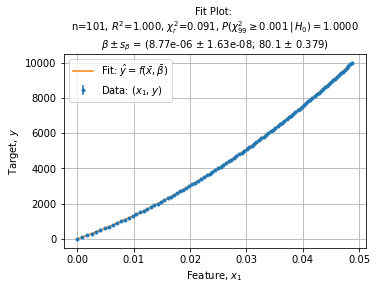

In [9]:
axe = model.plot_fit()

In [10]:
data

,t,V,xi,x1,x2
0,0.0,0.000000,0.000000,0.000000,0.000000
1,100.0,0.000021,0.000864,0.000348,-0.000348
2,200.0,0.000041,0.001706,0.000688,-0.000688
3,300.0,0.000060,0.002527,0.001019,-0.001019
4,400.0,0.000080,0.003327,0.001343,-0.001342
...,...,...,...,...,...
96,9600.0,0.001133,0.047415,0.019478,-0.019291
97,9700.0,0.001141,0.047756,0.019621,-0.019431
98,9800.0,0.001150,0.048097,0.019764,-0.019571
99,9900.0,0.001158,0.048436,0.019906,-0.019710
